In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<h1>
    <img src="../../docs/images/dataproc_cluster_insights_bigquery/dataproc-jobs-logo.png" alt="drawing" width="50"/> 
    Dataproc usage analysis
</h1>

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/dataproc_cluster_insights_bigquery.ipynb">
      <img src="https://avatars.githubusercontent.com/u/33467679?s=200&v=4" width="32px" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/dataproc_cluster_insights_bigquery.ipynb">
      <img src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/analytics/dataproc_cluster_insights_bigquery.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/analytics/dataproc_cluster_insights_bigquery.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fai-ml-recipes%2Fmain%2Fnotebooks%2Fanalytics%2Fdataproc_cluster_insights_bigquery.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
    Open in Colab Enterprise
    </a>
  </td>

</table>

## Table of contents<a id="index"></a>
* Overview
* Reference architecture
* Setup
* Imports
* Parameters
* Client and functions
* Run data extraction and preparation
* Explore data
* Visualize in Looker Studio

## <a id="overview"></a>Overview 

This notebooks show how to analyse Dataproc usage and billing. It uses the [Dataproc JobController](https://cloud.google.com/python/docs/reference/dataproc/latest/google.cloud.dataproc_v1.services.job_controller.JobControllerClient#google_cloud_dataproc_v1_services_job_controller_JobControllerClient_list_operations) python client to retrieve the service operations of type [dataproc.v1.ClusterOperationMetadata](https://cloud.google.com/python/docs/reference/dataproc/5.16.0/google.cloud.dataproc_v1.types.ClusterOperationMetadata). This operation logs cluster creation and deletion events. It also uses [BigQuery magics](https://cloud.google.com/python/docs/reference/bigquery/latest/magics) and [Bigframes API](https://cloud.google.com/python/docs/reference/bigframes/latest/summary_overview) to query, explore, and plot the data easily.

In addition, [Cloud Billing data](https://cloud.google.com/billing/docs/how-to/export-data-bigquery) exported in BigQuery is used to provide further insights about the usage cost.

## <a id="architecture"></a> Reference architecture

![dataproc-jobs-architecture.png](../../docs/images/dataproc_cluster_insights_bigquery/dataproc-jobs-architecture.png)

## <a id="setup"></a>Setup 

Pre-requisites:
* [Setup Cloud Billing export to BigQuery](https://cloud.google.com/billing/docs/how-to/export-data-bigquery)
* [Create a BigQuery dataset named **dataproc_analysis**](https://cloud.google.com/bigquery/docs/datasets#console)

Make sure the service account running this notebook has:
* [BigQueryDataViewer role](https://cloud.google.com/bigquery/docs/access-control#dataset_level) on the dataset used for Cloud Billing export
* [BigQueryDataEditor role](https://cloud.google.com/bigquery/docs/access-control#dataset_level) on the **dataproc_analysis** dataset
* Dataproc IAM permisions on [operations.list](https://cloud.google.com/dataproc/docs/concepts/iam/iam#operations_methods_required_permissions) and [workflowTemplates.list](https://cloud.google.com/dataproc/docs/concepts/iam/iam#workflow_templates_methods_required_permissions)

Considerations:
* This code will not retrieve nor ingest data incrementally, but historically. Then it will filter from the specified date.
* Tables will be re-created at each run.
* Code provided as a sample, not ready to production. Review with your organization.
* To protect large customer environments, there is a filter provided to limit the Dataproc client pager to only retrieve 5 pages of data. Remove it carefully after considering the volume of your organization.

**Install upgrade dependencies**

In [ ]:
pip install --upgrade google-api-core google-cloud-dataproc bigframes -q

**Make sure to restart Kernel**

## <a id="imports"></a>Imports

In [4]:
from google.cloud import dataproc_v1 as dataproc
from google.api_core import client_options
from google.longrunning.operations_pb2 import ListOperationsRequest
from typing import Sequence, Tuple, Union
from google.protobuf.json_format import MessageToJson 
import json
import pandas as pd
from google.cloud import bigquery
import time
import bigframes.pandas as bpd

## <a id="parameters"></a>Parameters 

- Provide your Google Cloud Project ID, region, and information for the Cloud Billing export in BigQuery (Dataset and table name).

- You can configure the start date from where the data will be presented.

- DATAPROC_PAGER_LIMIT allows you to limit how many request to the Dataproc API are made to retrieve past Operations. 

In [5]:
# Provide your GCP project ID
PROJECT_ID = "" 
# Provide your GCP region
GCP_REGION = "us-central1" 
# Provide your Cloud Billing export dataset
BQ_BILLING_DATASET_NAME = "gcp_billing" 
# Provide your Cloud Billing export table name
BQ_BILLING_TABLE_NAME = "gcp_billing_export_resource_v1_019CAE_7D7330_15385C" 

# Set reporting start date 
START_DATE = "2024-03-01"

# Limit Dataproc operation list pager
DATAPROC_PAGER_LIMIT = 5

In [6]:
# Do not change, unless necesary
BQ_DATASET_NAME = "dataproc_analysis"
BQ_TABLE_NAME_RAW = "operations_raw"
BQ_TABLE_NAME_CLEAN = "operations_clean"
BQ_TABLE_NAME_MODEL = "operations_model"
BQ_BILLING_TABLE_VIEW = "billing_model"

## <a id="client_functions"></a>Clients and functions 

In [7]:
client_options = client_options.ClientOptions(
    api_endpoint=f"{GCP_REGION}-dataproc.googleapis.com:443"
)
workflow_template_client = dataproc.WorkflowTemplateServiceClient(client_options=client_options)
bq_client = bigquery.Client()

In [8]:
def save_to_bq(table_id, df, schema = None):
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_APPEND",
        schema = schema
    )

    job = bq_client.load_table_from_dataframe(df, table_id, job_config=job_config) 
    return job.result()

## <a id="run_data"></a>Run data extraction and preparation 

#### 1. Prepare BigQuery tables

In [9]:
SQL_QUERY = f"""
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
    (
        clusterUuid STRING,
        clusterName STRING,
        operationType STRING,
        status STRING,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
    (
        clusterUuid STRING, 
        clusterName STRING,
        operationType STRING,
        stateStartTime STRING,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING
    );
    CREATE OR REPLACE TABLE {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    (
        clusterUuid STRING, 
        clusterName STRING,
        created TIMESTAMP,
        deleted TIMESTAMP,
        date DATE,
        hour INTEGER,
        master_instances STRING,
        master_machine_type STRING,
        worker_instances STRING,
        worker_machine_type STRING,
        seconds_elapsed INTEGER,
    );
"""

In [10]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

""


#### 2. List workflow templates

In [11]:
parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}"
request = dataproc.ListWorkflowTemplatesRequest(parent=parent)

In [12]:
page_result = workflow_template_client.list_workflow_templates(request=request)

In [13]:
workflow_templates = []

for response in page_result:
    workflow_templates.append({
        "name": response.name,
        "id": response.id
    })

#### 3. Get cluster operations and save them into BigQuery

In [14]:
def format_ops_data(ops):
    cluster_metadata = json.loads(MessageToJson(ops.metadata))
    ops = json.loads(MessageToJson(ops))
    
    response = ops.get("response", None)
    config = response.get("config", None) if response is not None else None

    # Master
    master_config = config.get("masterConfig", {"masterConfig": None}) if config is not None else None
    master_num_instances = master_config.get("numInstances", "") if master_config is not None else ""
    master_machineType = master_config.get("machineTypeUri", "") if master_config is not None else ""
    master_mathineType = master_machineType[master_machineType.rindex('/')+1:] if master_machineType != "" else ""

    # Worker
    worker_config = config.get("workerConfig", {"workerConfig": None}) if config is not None else None
    worker_num_instances = worker_config.get("numInstances", "") if worker_config is not None else ""
    worker_machineType = master_config.get("machineTypeUri", "") if worker_config is not None else ""
    worker_machineType = worker_machineType[worker_machineType.rindex('/')+1:] if worker_machineType != "" else ""
    
    return {
        "clusterName": cluster_metadata["clusterName"], 
        "clusterUuid": cluster_metadata["clusterUuid"], 
        "operationType": cluster_metadata["operationType"], 
        "status": cluster_metadata["status"],
        "master_instances": str(master_num_instances),
        "master_machine_type": master_mathineType,
        "worker_instances": str(worker_num_instances),
        "worker_machine_type": worker_machineType,
    }

In [15]:
def run_extract(filter_string):
    parent = f"projects/{PROJECT_ID}/regions/{GCP_REGION}/operations"
    operations_count = 0
    page_token = ""
    run_count = 0
    while True:
        run_count += 1
        time.sleep(0.5)
        
        if run_count > DATAPROC_PAGER_LIMIT:
            return operations_count

        operations = []
        request = ListOperationsRequest(
            name = parent,
            page_token = page_token,
            filter = filter_string
        )
        execution_request = workflow_template_client.list_operations(request=request)
        for ops in execution_request.operations:
            if ops.metadata.type_url == "type.googleapis.com/google.cloud.dataproc.v1.ClusterOperationMetadata":
                operations_count += 1
                cluster_metadata = format_ops_data(ops)
                operations.append(cluster_metadata)

        df = pd.DataFrame(operations)
        df["status"] = df["status"].apply(json.dumps)
        save_to_bq(
            table_id = f"{BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}",
            df = df
        )

        page_token = execution_request.next_page_token
        if page_token == '':
            return operations_count

In [16]:
operations_count = 0
filter_string = "operationType=CREATE"
operations_count += run_extract(filter_string)

filter_string = "operationType=DELETE"
operations_count += run_extract(filter_string)

In [17]:
f"{operations_count} operations found"

'86 operations found'

#### 4. Clean operations

In [18]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
      WITH operations_clean AS (
        SELECT 
            clusterUuid
            , clusterName
            , operationType
            , JSON_VALUE(PARSE_JSON(status), '$.stateStartTime') stateStartTime
            , master_instances
            , master_machine_type
            , worker_instances
            , worker_machine_type
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_RAW}
          WHERE 
              --JSON_VALUE(PARSE_JSON(status), '$.innerState') = 'DONE'
              JSON_VALUE(PARSE_JSON(status), '$.state') = 'DONE'
      )
      , created AS (
        SELECT
            *
            , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime ASC) cluster_group
        FROM operations_clean 
        WHERE 
            operationType = 'CREATE'
            AND DATE(stateStartTime) >= DATE('{START_DATE}')
        GROUP BY ALL
        ORDER BY stateStartTime
      )
      , deleted AS (
        SELECT
        *
        , RANK() OVER ( PARTITION BY clusterUuid ORDER BY stateStartTime DESC ) cluster_group
        FROM operations_clean 
        WHERE operationType = 'DELETE' AND clusterUuid IN (SELECT clusterUuid FROM created GROUP BY 1)
        GROUP BY ALL
        ORDER BY stateStartTime
      )
      SELECT 
          * EXCEPT (cluster_group)
      FROM created
      WHERE cluster_group = 1
      UNION ALL
      SELECT 
          * EXCEPT (cluster_group)
      FROM deleted
      WHERE cluster_group = 1
"""

In [19]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

""


#### 5. Model cluster usage

In [20]:
SQL_QUERY = f"""
    INSERT INTO {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
        WITH cluster_create AS (
          SELECT 
              clusterUuid, clusterName, TIMESTAMP(stateStartTime) stateStartTime,
              master_instances, master_machine_type, worker_instances, worker_machine_type
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'CREATE'
        )
        , cluster_delete AS (
          SELECT clusterUuid, TIMESTAMP(stateStartTime) stateStartTime
          FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_CLEAN}
          WHERE operationType = 'DELETE'
        )
        SELECT 
            cluster_create.clusterUuid
          , cluster_create.clusterName
          , cluster_create.stateStartTime AS created
          , cluster_delete.stateStartTime AS deleted
          , extract(DATE from cluster_create.stateStartTime) date
          , extract(HOUR from cluster_create.stateStartTime) hour
          , master_instances
          , master_machine_type
          , worker_instances
          , worker_machine_type
          , TIMESTAMP_DIFF(cluster_delete.stateStartTime, cluster_create.stateStartTime, SECOND) AS seconds_elapsed
         FROM cluster_create
        LEFT JOIN cluster_delete
        USING (clusterUuid)
        GROUP BY 1,2,3,4,5,6,7,8,9,10
"""

In [21]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

""


## <a id="explore"></a>Explore data 

#### Total seconds by time

In [22]:
SQL_QUERY = f"""
    SELECT 
          date
        , hour
        , concat(date, ' ', hour, ':00') date_hour
        , sum(seconds_elapsed) / 60 minutes
    FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
    GROUP BY 1,2,3
    ORDER BY 3
"""

In [23]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

Downloading:   0%|          |

,date,hour,date_hour,minutes
0,2024-03-21,0,2024-03-21 0:00,32.550000
1,2024-03-21,21,2024-03-21 21:00,30.366667
2,2024-04-22,15,2024-04-22 15:00,10.366667
3,2024-05-29,20,2024-05-29 20:00,30.066667
4,2024-06-04,13,2024-06-04 13:00,29.833333
5,2024-06-18,12,2024-06-18 12:00,30.016667
6,2024-09-03,21,2024-09-03 21:00,2.433333
7,2024-11-27,14,2024-11-27 14:00,31.216667
8,2025-02-12,17,2025-02-12 17:00,4.333333
9,2025-02-12,18,2025-02-12 18:00,4.933333


<Axes: xlabel='date_hour'>

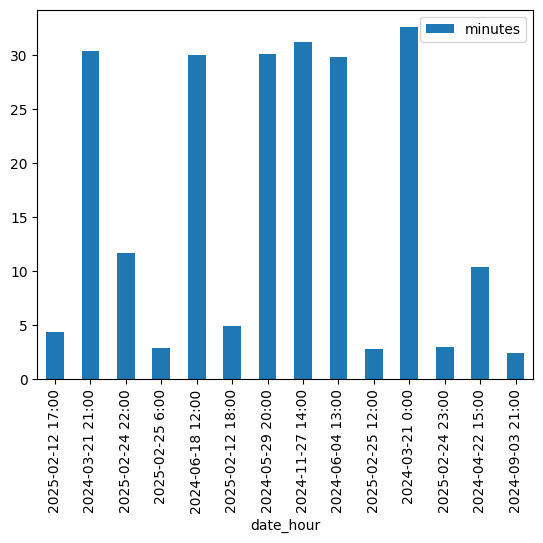

In [24]:
df = bpd.read_gbq(SQL_QUERY)
df[["date_hour", "minutes"]].plot.bar(x="date_hour", y="minutes")

#### Cluster details

In [25]:
SQL_QUERY = f"""
SELECT 
      date
    , hour
    , clusterUuid
    , clusterName
    , seconds_elapsed / 60 minutes
FROM {BQ_DATASET_NAME}.{BQ_TABLE_NAME_MODEL}
ORDER BY 1,2,3
"""

In [26]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

Downloading:   0%|          |

,date,hour,clusterUuid,clusterName,minutes
0,2024-03-21,0,7c7f0f34-76e5-422b-9b10-27c319dea982,srvls-session-7ae4c720-8e54-477e-b33b-a9cecc62...,2.383333
1,2024-03-21,0,f177a280-8efc-42fe-885d-edc8ff76f64c,srvls-session-0b40ab36-883c-4ec1-93f5-43efb647...,30.166667
2,2024-03-21,21,199a2ebc-e287-40a8-a7e6-701042cd6663,srvls-session-8f4207ee-921a-4593-86b5-ead3d406...,30.366667
3,2024-04-22,15,08273726-b69e-488a-a813-c0e287b9bf0b,srvls-session-d6c9fdd2-b4d5-49ad-9853-fd283347...,10.366667
4,2024-05-29,20,fc36f463-6de5-4f4d-972a-7e7a0cccdaa0,srvls-session-d9f26ba6-6140-47f6-9f6d-c3c17da5...,30.066667
5,2024-06-04,13,ecd1fe28-354f-4eea-863e-745b02462c85,srvls-session-ccc4f4ef-de25-4aaf-aa07-1442776b...,29.833333
6,2024-06-18,12,fbaac46a-e25c-454b-8617-261ec75a4c07,srvls-session-ad7438cc-23a6-41c0-9dc1-b116f8a8...,30.016667
7,2024-09-03,21,b7dc43ed-9556-462f-b1f4-540c080a678c,srvls-session-5153a351-3d2f-4f8f-861f-339a24f1...,2.433333
8,2024-11-27,14,44ae9df0-467d-4cc8-9b37-ef8a5dabbfa0,srvls-session-58fe92c0-55f3-4bea-91aa-a05852a4...,31.216667
9,2025-02-12,17,68aac871-dac9-4534-9dba-b3b94adb4925,cluster-f6ef-ktklml7lgv4wa,2.783333


#### Total price by the hour

In [27]:
SQL_QUERY = f"""
    SELECT 
      CONCAT(
          EXTRACT (DATE FROM usage_start_time),
          ' ',
          EXTRACT (HOUR FROM usage_start_time),
          ' :00'
       ) date_hour,
      sku.id sku_id, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
      AND DATE(usage_start_time) >= DATE('{START_DATE}')
    GROUP BY 1,2,3
    ORDER BY 1
"""

In [28]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

Downloading:   0%|          |

,date_hour,sku_id,effective_price,amount_in_pricing_units,total_price
0,2024-03-21 0 :00,A486-6040-07FE,0.000089000,11721.573333,1.043220
1,2024-03-21 21 :00,A486-6040-07FE,0.000089000,22043.298611,1.961854
2,2024-03-23 0 :00,A065-18C2-08FA,0.000100232,10963.938611,1.098937
3,2024-03-23 1 :00,A065-18C2-08FA,0.000100232,11849.999167,1.187749
4,2024-03-23 10 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749
5,2024-03-23 11 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749
6,2024-03-23 12 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749
7,2024-03-23 13 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749
8,2024-03-23 14 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749
9,2024-03-23 15 :00,A065-18C2-08FA,0.000100232,11850.000000,1.187749


<Axes: xlabel='date_hour'>

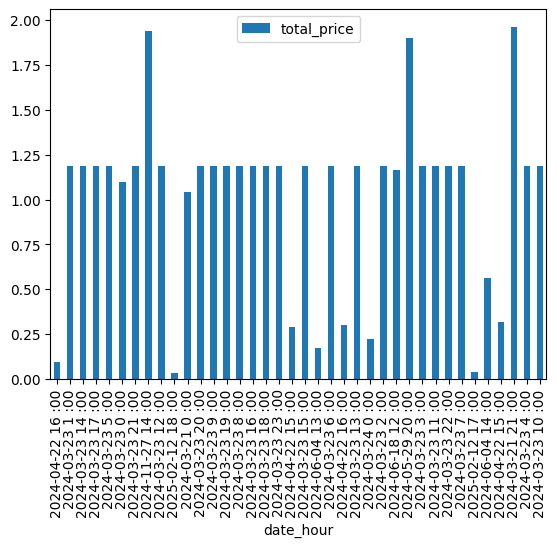

In [29]:
df = bpd.read_gbq(SQL_QUERY)
df[["date_hour", "total_price"]].plot.bar(x="date_hour", y="total_price")

#### Billing details by SKU and hour

In [30]:
SQL_QUERY = f"""
    CREATE OR REPLACE MATERIALIZED VIEW {BQ_DATASET_NAME}.{BQ_BILLING_TABLE_VIEW} AS
    SELECT 
      EXTRACT (DATE FROM usage_start_time) date,
      EXTRACT (HOUR FROM usage_start_time) hour,
      sku.id sku_id, 
      sku.description sku_description, 
      price.effective_price / price.pricing_unit_quantity effective_price,
      SUM(usage.amount_in_pricing_units) amount_in_pricing_units, 
      SUM(usage.amount_in_pricing_units * price.effective_price / price.pricing_unit_quantity) total_price
    FROM {BQ_BILLING_DATASET_NAME}.{BQ_BILLING_TABLE_NAME}
    WHERE 
      service.description = 'Dataproc' 
      AND sku.description LIKE 'Data Compute Unit (milli) Hours%'
      AND DATE(usage_start_time) >= DATE('{START_DATE}')
    GROUP BY 1,2,3,4,5;
    
    SELECT * FROM {BQ_DATASET_NAME}.{BQ_BILLING_TABLE_VIEW} ORDER BY 1,2;
"""

In [31]:
%%bigquery
$SQL_QUERY

Query is running:   0%|          |

Downloading:   0%|          |

,date,hour,sku_id,sku_description,effective_price,amount_in_pricing_units,total_price
0,2024-03-21,0,A486-6040-07FE,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000089000,11721.573333,1.043220
1,2024-03-21,21,A486-6040-07FE,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000089000,22043.298611,1.961854
2,2024-03-23,0,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,10963.938611,1.098937
3,2024-03-23,1,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11849.999167,1.187749
4,2024-03-23,2,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
5,2024-03-23,3,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
6,2024-03-23,4,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
7,2024-03-23,5,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
8,2024-03-23,6,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749
9,2024-03-23,7,A065-18C2-08FA,Data Compute Unit (milli) Hours - Dataproc Ser...,0.000100232,11850.000000,1.187749


## <a id="visualize"></a>Visualize in Looker Studio 

With the refined tables **operations_model** and **billing_model** in your dataset **dataproc_analysis**, you can now generate the following dashboard in Looker Studio. This can provide business and FinOps users a simple pane of glass to understad Dataproc cluster usage and billing.

![dataproc-jobs.png](../../docs/images/dataproc_cluster_insights_bigquery/dataproc-jobs.png)